<center><font size = "10"> Week 7 - Connections <center>
<center><font size = "8">Home work<center>

<font size = "3">Please, write your group number and the names and surnames of the group members here
<br>Group number: 8
<br>Group member1: Chiara Maria Matti
<br>Group member2: Elena Grazia Gado
<br>Group member3: Eliser Josan Romero

In [1]:
# Load useful packages
import os
from neuron import h, gui
import numpy as np
import math as m
import random as rd
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

--No graphics will be displayed.


# <font color='red'> Ex1: </font> Connect all-to-all with random weights.

<font size='3'>In week 3 Home Works (Morphologies) each group received a set of ten morphology files to check their quality. Each set of cells have __FIVE__ good morphology files.

<font size='3'> For this exercise, connect your five cells all to all (unidirectionally) with random weights, as it is done in tutorial 01 of this week, and display the connectivity matrix with the weights.
    
<font color= 'red'>[1.5 pts]

In [2]:
# path
data_path = "../Week_3/input/group_08/"
correct_morpho = [0, 1, 3, 4, 6]
#get correct morpho files

morph_path =[]
for file in os.listdir(data_path):
    for i in correct_morpho:
        if str(i) in file:
            morph_path.append(data_path + file)
morph_path

['../Week_3/input/group_08/morph_1.swc',
 '../Week_3/input/group_08/morph_4.swc',
 '../Week_3/input/group_08/morph_3.swc',
 '../Week_3/input/group_08/morph_0.swc',
 '../Week_3/input/group_08/morph_6.swc']

### Generating our cells of interest

In [3]:
class Cell:
    def __init__(self, filename, name, cell_type):
        self.name = name
        self.type = cell_type
        self.synapses = []
        self.build_morphology(filename)
        self.biophysics()
        
    def build_morphology(self, filename):
        h.load_file('import3d.hoc')
        h.load_file('stdlib.hoc')
        #morph_reader = h.Import3d_Neurolucida3()
        morph_reader = h.Import3d_SWC_read()
        morph_reader.input(filename)
        i3d = h.Import3d_GUI(morph_reader, 0)
        i3d.instantiate(self) # Notice this change to be able to instantiate several cells
    
    def biophysics(self):
        for sec in h.allsec():
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
            sec.insert("pas")
            for seg in sec:
                seg.pas.g = 0.00003
                seg.pas.e = -75
        
        # Insert passive current in the dendrite
        for sec in self.soma:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        if hasattr(self, 'apic'):
            for sec in self.apic:
                sec.insert('hh')
                for seg in sec:
                    seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                    seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        for sec in self.dend:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
                
        for sec in self.axon:
            sec.insert('hh')
            for seg in sec:    
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

In [4]:
# cell generation
cells = []
for i, morph in zip(correct_morpho, morph_path):
    cells.append(Cell(morph,f'Morph_{i}', 'Morpho'))

In [5]:
for c in cells:
    if hasattr(c, "apic"):
        c.type = "PC" # pyramidal cell because there is a distinction of apical and basal dendrites
        print('%s: %d apical sections, %d basal sections, %d soma sections and %d axon sections and is a %s neuron' % (c.name,len(c.apic),len(c.dend), len(c.soma), len(c.axon), c.type))
    else:
        c.type = "Inh" # only basal dendrites so might be because no distinction between basal and apical cf. week3
        print('%s: %d basal sections, %d soma sections and %d axon sections and is a %s neuron' % (c.name,len(c.dend), len(c.soma), len(c.axon), c.type))
        

Morph_0: 24 basal sections, 1 soma sections and 381 axon sections and is a Inh neuron
Morph_1: 29 apical sections, 38 basal sections, 1 soma sections and 217 axon sections and is a PC neuron
Morph_3: 40 basal sections, 1 soma sections and 449 axon sections and is a Inh neuron
Morph_4: 39 apical sections, 41 basal sections, 1 soma sections and 118 axon sections and is a PC neuron
Morph_6: 37 apical sections, 69 basal sections, 1 soma sections and 67 axon sections and is a PC neuron


### Connecting all to all (uni-directional) with random weigths

In [6]:
# returns NxN matrix of random weights in [0,1) with zero diagonal
def random_weights(n):
    rng = np.random.default_rng()
    weights = rng.random((n,n))
    np.fill_diagonal(weights,0.0)
    return weights

# connect two cells with an exponential synapse at given locations
# returns the netcon
def connect(source, target, weight = None, delay = 5, source_sec = None, source_neurite = 'axon', target_sec = None, target_neurite = 'dend'):
    rng = np.random.default_rng()
    
    if weight is None:
        weight = rng.uniform() # random weight
    
    target_neurite_ = getattr(target, target_neurite)
    if target_sec is None:
        target_sec = rng.integers(0,len(target_neurite_)) # random dendritic section
    
    source_neurite_ = getattr(source, source_neurite)
    if source_sec is None:
        source_sec = rng.integers(0,len(source_neurite_)) # random axonal section
    
    target_syn = h.ExpSyn(target_neurite_[target_sec](0.5))
    target.synapses.append(target_syn) # store synapse
    
    netcon = h.NetCon(source_neurite_[source_sec](0.5)._ref_v, target_syn, sec=source_neurite_[source_sec])
    netcon.weight[0] = weight
    netcon.delay = delay
    
    print('Connected cells %s -> %s with weight %g and delay %g, from %s[%d] to %s[%d]' % (source.name,target.name,weight,delay,source_neurite,source_sec,target_neurite,target_sec))
    return netcon

# form unidirectional pairs
def connect_all(X, weight_matrix):
    netcons = [] # store all netcons
    connections = {}
    for i, x_i in enumerate(X):
        for j, x_j in enumerate(X):
            if i != j:  # To avoid connecting x_i to itself
                if x_i not in connections:
                    connections[x_i] = set()
                connections[x_i].add(x_j)  # Connect x_i to x_j

    for x, connected_nodes in connections.items():
        for node in connected_nodes:
            weight = weight_matrix[X.index(x)][X.index(node)]
            netcons.append(connect(x, node, weight))  # Perform the connection using the function f and weight
    return netcons

In [7]:
# random matrix weight
weight_matrix = random_weights(5)
# connecting all 5 cells
netcons =connect_all(cells, weight_matrix)

Connected cells Morph_0 -> Morph_1 with weight 0.0797778 and delay 5, from axon[252] to dend[20]
Connected cells Morph_0 -> Morph_4 with weight 0.661705 and delay 5, from axon[188] to dend[19]
Connected cells Morph_0 -> Morph_6 with weight 0.104228 and delay 5, from axon[80] to dend[50]
Connected cells Morph_0 -> Morph_3 with weight 0.8864 and delay 5, from axon[291] to dend[10]
Connected cells Morph_1 -> Morph_0 with weight 0.445227 and delay 5, from axon[199] to dend[23]
Connected cells Morph_1 -> Morph_4 with weight 0.893149 and delay 5, from axon[52] to dend[27]
Connected cells Morph_1 -> Morph_6 with weight 0.873674 and delay 5, from axon[158] to dend[25]
Connected cells Morph_1 -> Morph_3 with weight 0.194656 and delay 5, from axon[152] to dend[27]
Connected cells Morph_3 -> Morph_0 with weight 0.444233 and delay 5, from axon[43] to dend[21]
Connected cells Morph_3 -> Morph_4 with weight 0.103443 and delay 5, from axon[67] to dend[11]
Connected cells Morph_3 -> Morph_6 with weigh

### Testing connectivity

In [8]:
def stimulation(cell1, cell2, dend_num = 1, n_stim = 10, start = 10, delay = 10, weight= 0.8): 
    stim_cell = cell1
    stim_syn = h.ExpSyn(stim_cell.dend[dend_num](0.5))
    stim = h.NetStim() # Make a new stimulator
    ncstim = h.NetCon(stim, stim_syn) # Connect stimulator to synapse

    stim.number = n_stim # Number of spikes (average)
    stim.start = start # First spike delay [ms]
    ncstim.delay = delay # NetCon ms
    ncstim.weight[0] = weight # NetCon weight

    recording_cell = cell2

    soma_v = h.Vector().record(recording_cell.soma[0](0.5)._ref_v)
    dend_v = h.Vector().record(recording_cell.dend[dend_num](0.5)._ref_v)
    time = h.Vector().record(h._ref_t)

    h.finitialize(-65)
    h.continuerun(100)

    fig, ax = plt.subplots()

    ax.plot(time, soma_v, label='soma(0.5)')
    ax.plot(time, dend_v,  label='dend(0.5)')

    ax.set_title("Cell response to synapse stimuli", fontsize = 15)
    ax.set_xlabel("Time (ms)", fontsize = 12)
    ax.set_ylabel("Voltage (mV)", fontsize = 12)
    ax.legend(loc='upper right')

    plt.show()

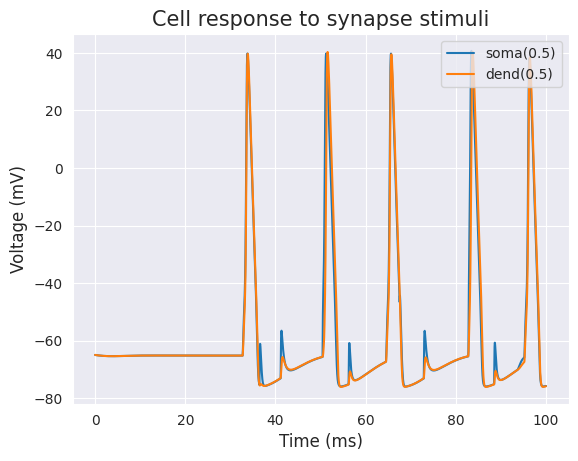

In [9]:
stimulation(cells[1],cells[0], dend_num = 19, n_stim = 10, start = 10, delay = 1, weight= 0.8)

### Weight matrix connection

In [10]:
def plot_heatmap(weight_mat, cell_lab, title, cbarlabel):
    """
    Create a heatmap from a pandas DataFrame.

    Parameters
    ----------
    weight_mat
        A 2D numpy array of shape (N, M).
    cell_lab
        A list or array of length N with the cell labels
    title
        The plot label
    cbarlabel
        The label for the colorbar.  Optional.
        
    """
    df = pd.DataFrame(weight_mat, columns= cell_lab, index= cell_lab)
    
    plt.figure()
    ax = sns.heatmap(df, annot=True, linewidths=0.1, vmax=1)
    ax.xaxis.tick_top()
    ax.set_title(title, fontsize = 15)
    ax.collections[0].colorbar.set_label(cbarlabel)
    plt.tight_layout()
    plt.show()

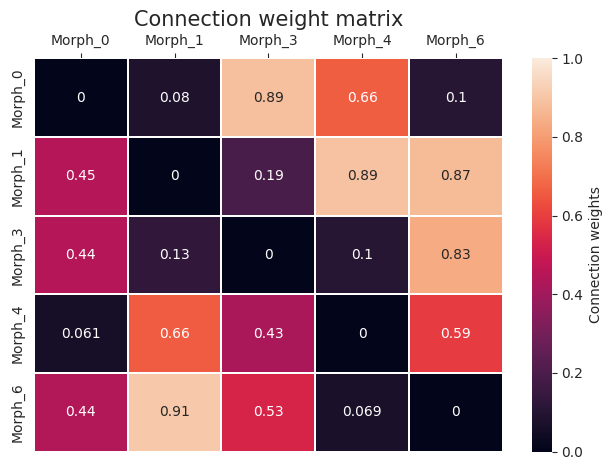

In [11]:
cell_label = []
for c in cells:
    cell_label.append(c.name)
cell_label

plot_heatmap(weight_matrix, cell_label, title = "Connection weight matrix", cbarlabel = "Connection weights")

### **Grading**: 
- <font color= 'red'>[0.5 pts]</font> for a clear setup of all the functions you need
- <font color= 'red'>[0.5 pts]</font> for a step by step process loading cells and connecting them
- <font color= 'red'>[0.5 pts]</font> for connection weights plot, with labels and legend

# <font color='red'> Ex2: </font> Connect your cells considering connection probability

<font size='3'> Connect your five cells as it is done in tutorial 02, considering the following connection probabilities between cell types:<br>
<br> PC - PC: 65 %
<br> PC - Inh: 23 %
<br> Inh - PC: 41 %
<br> Inh - Inh: 36 %

<font size='3'> Then show the results on a probability matrix.
    
<font color= 'red'>[1 pt]

### Connecting all to all (uni-directional) with given weigths¶

In [12]:
# connecting but with probability
def connect_all_2(cells, probabilities):
    netcons = [] # store all netcons
    rng = np.random.default_rng()
    for i, cell_i in enumerate(cells):
        for j, cell_j in enumerate(cells):
            if i != j:
                connection_probability = probabilities.get((cell_i.type, cell_j.type), 0)
                if rng.random() < connection_probability:
                    netcons.append(connect(cell_i, cell_j))
    return netcons
                    

In [13]:
# generating weight matrix
probabilities = {
    ('PC', 'PC'): 0.65,
    ('PC', 'Inh'): 0.23,
    ('Inh', 'PC'): 0.41,
    ('Inh', 'Inh'): 0.36
}
#connecting all 5 cells
netcons_2 = connect_all_2(cells, probabilities)

Connected cells Morph_0 -> Morph_1 with weight 0.80512 and delay 5, from axon[84] to dend[9]
Connected cells Morph_0 -> Morph_3 with weight 0.617258 and delay 5, from axon[279] to dend[22]
Connected cells Morph_0 -> Morph_6 with weight 0.874875 and delay 5, from axon[129] to dend[11]
Connected cells Morph_1 -> Morph_4 with weight 0.583917 and delay 5, from axon[39] to dend[2]
Connected cells Morph_1 -> Morph_6 with weight 0.872124 and delay 5, from axon[41] to dend[61]
Connected cells Morph_3 -> Morph_0 with weight 0.322748 and delay 5, from axon[409] to dend[14]
Connected cells Morph_6 -> Morph_1 with weight 0.406545 and delay 5, from axon[31] to dend[7]
Connected cells Morph_6 -> Morph_3 with weight 0.535787 and delay 5, from axon[52] to dend[26]
Connected cells Morph_6 -> Morph_4 with weight 0.00393175 and delay 5, from axon[48] to dend[32]


### Testing connectivity

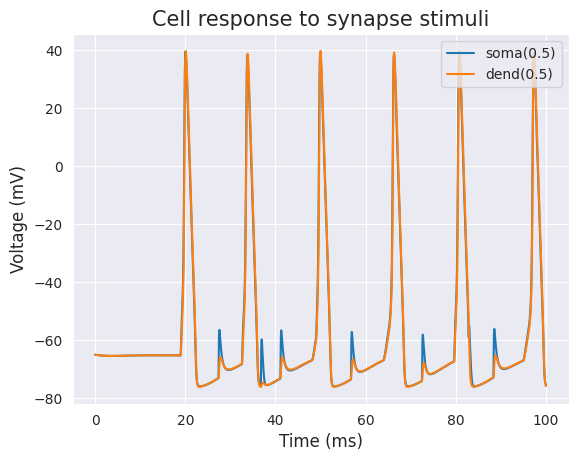

In [14]:
stimulation(cells[4],cells[0], dend_num = 19, n_stim = 10, start = 10, delay = 1, weight= 0.8)

### Weight matrix connection

In [15]:

# Convert probabilities to a DataFrame
# Create a matrix of lists based on the probabilities
cell_types = ['PC', 'Inh']
probabilities_matrix = [
    [probabilities.get((cell_type_1, cell_type_2), 0) for cell_type_2 in cell_types]
    for cell_type_1 in cell_types
]
probabilities_matrix # Display the DataFrame

[[0.65, 0.23], [0.41, 0.36]]

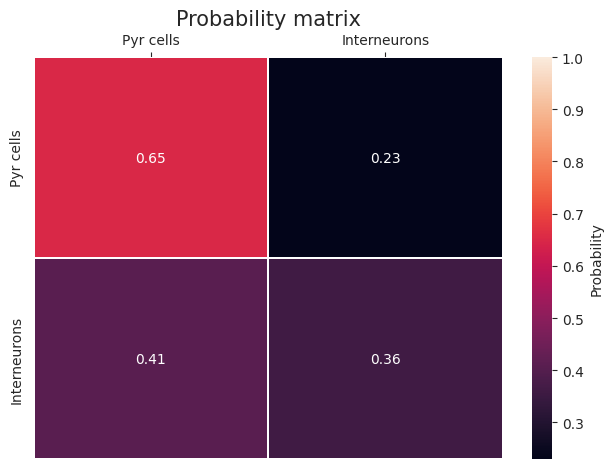

In [16]:
labels = ["Pyr cells", "Interneurons"]
plot_heatmap(probabilities_matrix, cell_lab= labels, title = "Probability matrix", cbarlabel = "Probability")

### **Grading**: 
- <font color= 'red'>[0.5 pts]</font> for a step by step process loading cells and connecting them
- <font color= 'red'>[0.5 pts]</font> for probability matrix plot

# <font color='red'> Ex3: </font> Distribution of contacts: Convergence Matrix

<font size='3'> Consider the following mean contact points between cell types: 
<br> PC_axon - PC_basal: 4
<br> PC_axon - PC_apical: 1.5
<br> PC_axon - Inh_basal: 3
<br> Inh_axon - PC_soma: 3.5
<br> Inh_axon - PC_basal: 2
<br> Inh_axon - Inh_soma: 4
<br> Inh_axon - Inh_basal: 1.6

<font size='3'> Connect your cells by selecting the contact points from a normal distribution with a specific mean value per connection (values above). 
    
<font size='3'> Show the results on a __convergence__ matrix (how many contacts each of the cells receives from the others). 
    
<font color= 'red'>[2 pts]

### **Grading**: 
- <font color= 'red'>[1 pt]</font> for correct cell connections
- <font color= 'red'>[1 pt]</font> for the convergence matrix plot, with labels and legend

# <font color='red'> Ex4: </font>  Real Connectivity Rules

<font size='3'> Imagine that you have to build a network with your five cells (3 pyramidals and 2 GABAergic interneurons) from rat somatosensory cortex. <br> In this situation you'd have to extract real connectivity rules for articles and decide how you can use them as parameters.
    
<font size='3'> For this exercise read the short Gupta et al. (2000) paper provided and digest it, writing below all the points that seem important when thinking about connectivity rules for various Int --> Int and Int --> Pyr.
    
<font size='3'> Use a mix of bullet points and complete sentences to summarise and comment every piece of information. Take some time with expressing your ideas precisely and concisely. Consider it exam practice.    
    
<font color= 'red'> [1.5 pts]
    
<font size='3'> _Hint_: If you need help, you can follow these points:
    1) give an overview of the paper and the parameters they report
    2) what is the overall connection probability for the cells they are examining?
    3) what are the three different classes of GABAergic synapses they observed?
    4) what are the three principles of synapse formation they mention?

### **Grading levels**: 
- <font color= 'red'>[1.5 pts]</font> if summary contains >80% of the points in the reference answer, well organised
- <font color= 'red'>[1.2 pts]</font> if summary contains ~70% of the points in the reference answer
- <font color= 'red'>[0.8 pts]</font> if summary contains ~50% of the points in the reference answer
- <font color= 'red'>[0.4 pts]</font> if summary contains <30% of the points in the reference answer